In [1]:
import torch
import torch.nn as nn
import sys

sys.path.append('../Natural Language Processing/')

from NLP_utils import *
import matplotlib.pyplot as plt
import time

# GRU

In [2]:
class GRU(nn.Module):
    # Can use nn.GRU, but will do from scratch
    def __init__(self, input_size, hidden_size, output_size) -> None:
        super(GRU, self).__init__() # Calling the super class __init__ function

        self.hidden_size = hidden_size
        
        self.candidate = nn.Linear(input_size+hidden_size, hidden_size)
        self.gamma_u = nn.Linear(input_size+hidden_size, hidden_size)
        self.gamma_r = nn.Linear(input_size+hidden_size, hidden_size)

        self.hid2out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim = 1) # Input = (1,57) so will need to use the second dimension, hence dim = 1
    
    def forward(self, xt, c_prev): # One cell forward pass
        combined = torch.cat((xt, c_prev), 1) # Concat along dimension 1
        relevance_gate = torch.sigmoid(self.gamma_r(combined))

        combined_cand = torch.cat((xt, relevance_gate * c_prev), 1)

        candidate = torch.tanh(self.candidate(combined_cand))
        update_gate = torch.sigmoid(self.gamma_u(combined))
        
        c_next = update_gate * candidate + (1 - update_gate) * c_prev

        yt = self.softmax(self.hid2out(c_next))
        return(yt, c_next)
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
category_lines, all_categories = load_data()

# Number of categories -
# (Number of different languages .txt files we have)
n_categories = len(all_categories)
print(n_categories)

18


In [4]:
n_hidden = 256 # Hyperparameter we can set (Size of hidden state)

In [5]:
gru = GRU(N_LETTERS, n_hidden, n_categories)

In [6]:
# One step through the RNN cell
input_tensor = letter_to_tensor('A')
hidden_tensor = gru.init_hidden() # Vector of zeros

In [7]:
output, next_hidden = gru(input_tensor, hidden_tensor)

In [8]:
print(output)

tensor([[-2.9404, -2.9497, -2.9090, -2.8439, -2.9241, -2.8575, -2.8362, -2.8487,
         -2.9238, -2.8805, -2.8661, -2.9263, -2.8877, -2.9583, -2.8593, -2.8629,
         -2.8429, -2.9233]], grad_fn=<LogSoftmaxBackward0>)


In [9]:
print(output.size()) # Number of categories
print(next_hidden.size()) # Hidden size

torch.Size([1, 18])
torch.Size([1, 256])


# Prediction Trial

In [10]:
input_tensor1 = line_to_tensor('Albert')
hidden_tensor1 = gru.init_hidden()

In [11]:
input_tensor1.shape # (Number of letters, 1, Number of total possible ASCII characters = 57)

torch.Size([6, 1, 57])

In [12]:
output, next_hidden = gru(input_tensor1[0], hidden_tensor1)
print(output.size())
print(next_hidden.size())
# print(output)
# print(next_hidden)

torch.Size([1, 18])
torch.Size([1, 256])


In [13]:
torch.argmax(output)

tensor(6)

In [14]:
def category_from_output(output):
    idx = torch.argmax(output).item()
    return all_categories[idx] # Returns the respective language

In [15]:
print(category_from_output(output)) # Its untrained hence it prints any random language

Russian


# Training

In [16]:
criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(gru.parameters(), lr = learning_rate)

In [17]:
def train(line_tensor, category_tensor):
    """
        line_tensor: Whole line as a tensor of one_hot encoded letters
        category_tensor: index of the class label in one-hot encoded form of shape - [1, n_categories] (n_categories = 18 here)
    """
    hidden = gru.init_hidden()

    for i in range(line_tensor.shape[0]):
        output, hidden = gru(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    optimizer.zero_grad()
    with torch.autograd.set_detect_anomaly(True):
        loss.backward()
    optimizer.step()

    return output, loss.item() # Loss as float value

In [18]:
current_loss = 0
all_losses = []

# After 1000 steps - plot
# After 5000 steps - print
plot_steps, print_steps = 1000, 5000 
n_iters = 100000

In [19]:
tic = time.time()
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines = category_lines, all_categories = all_categories)
    output, loss = train(line_tensor, category_tensor) # One iteration of training
    current_loss+=loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
    
    if (i+1) % print_steps == 0:
        prediction = category_from_output(output)
        # category = true category label
        # Basically we do a single prediction every 5000 steps (= print_steps)
        correct = "CORRECT!" if prediction == category else f'WRONG! ({category})'
        print(f'Epoch {i+1}; {(i+1)/n_iters * 100:.0f}% complete; Loss = {loss:.4f}; {line} / {prediction} {correct}')
print(f'Finished Training in {(time.time()-tic)//60:.0f}m {(time.time()-tic)%60:.0f}s')

Epoch 5000; 5% complete; Loss = 2.7649; Faltejsek / Portuguese WRONG! (Czech)
Epoch 10000; 10% complete; Loss = 2.6759; Wolter / French WRONG! (German)
Epoch 15000; 15% complete; Loss = 2.3585; Berezovikov / Greek WRONG! (Russian)
Epoch 20000; 20% complete; Loss = 3.1086; Bonfils / Greek WRONG! (French)
Epoch 25000; 25% complete; Loss = 2.6304; O'Connell / German WRONG! (Irish)
Epoch 30000; 30% complete; Loss = 1.3713; Zou / Korean WRONG! (Chinese)
Epoch 35000; 35% complete; Loss = 1.1924; Kieu / Vietnamese CORRECT!
Epoch 40000; 40% complete; Loss = 0.8757; Tadhgan / Irish CORRECT!
Epoch 45000; 45% complete; Loss = 0.7501; Cardozo / Portuguese CORRECT!
Epoch 50000; 50% complete; Loss = 1.9404; Soukup / Polish WRONG! (Czech)
Epoch 55000; 55% complete; Loss = 1.6586; Banos / Portuguese WRONG! (Greek)
Epoch 60000; 60% complete; Loss = 1.8129; Tovey / English CORRECT!
Epoch 65000; 65% complete; Loss = 0.7510; Chu / Vietnamese CORRECT!
Epoch 70000; 70% complete; Loss = 1.6966; Albuquerque /

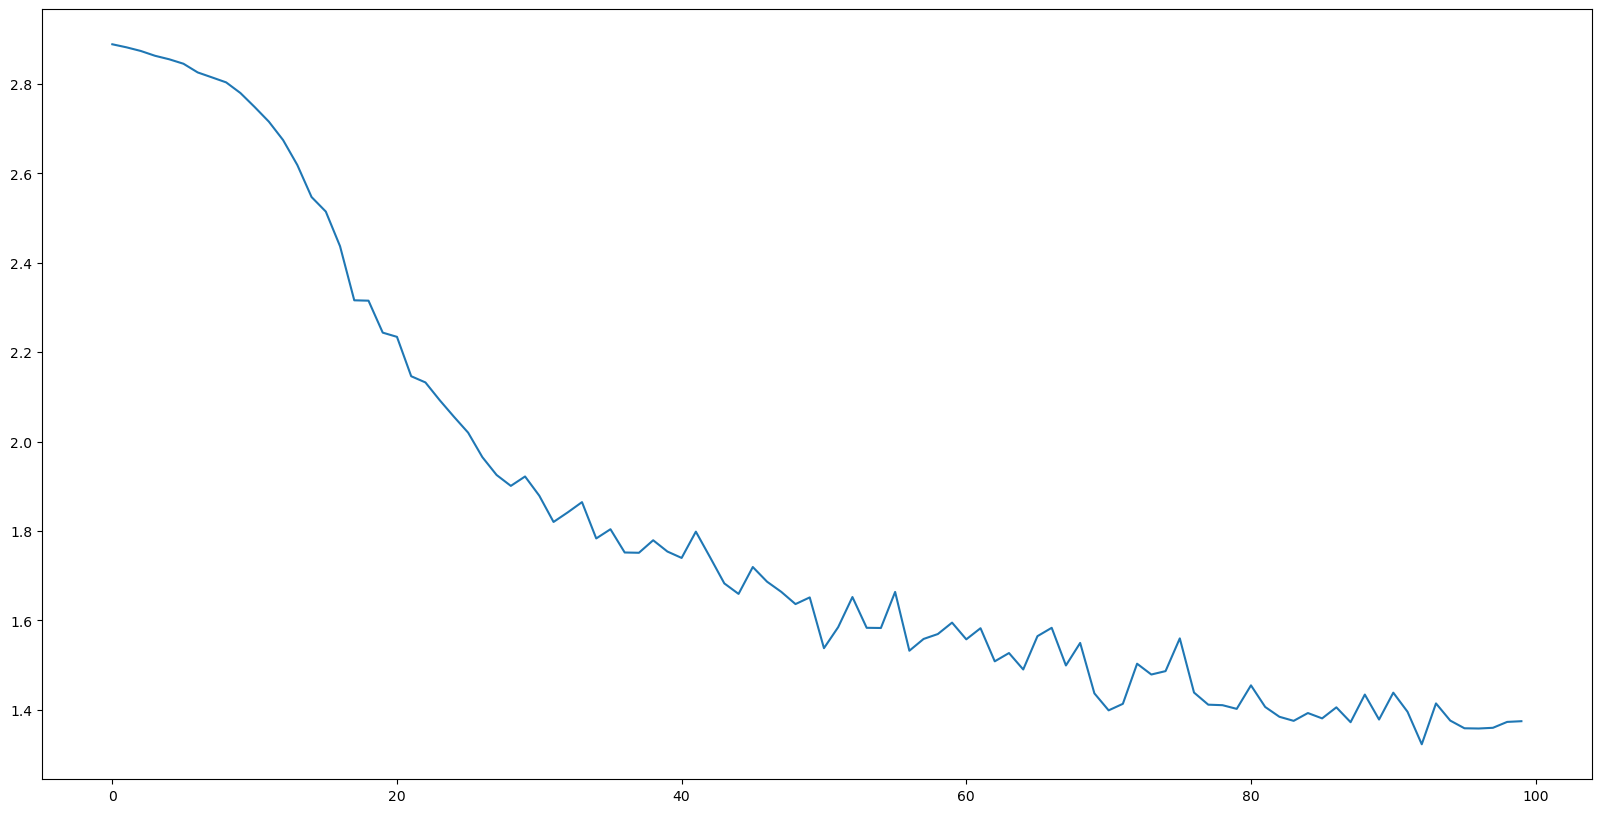

In [20]:
plt.figure(figsize = (20,10))
plt.plot(all_losses)
plt.show()

In [23]:
def predict(input_line):
    print(f'\n> {input_line}')
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        hidden = gru.init_hidden()

        for i in range(line_tensor.shape[0] - 1):
            _, hidden = gru(line_tensor[i], hidden)

        output, hidden = gru(line_tensor[i+1], hidden)
        prediction = category_from_output(output)
        print('Prediction:', prediction)

In [24]:
while True:
    sentence = input("INPUT: ")
    if sentence == 'quit':
        break
    predict(sentence)


> Bao
Prediction: Chinese

> Gerard
Prediction: French

> Richman
Prediction: Irish

> Mahmood
Prediction: Arabic

> Abl
Prediction: German

> Abel
Prediction: German
